# Análisis del data set de Telecomunicaciones para entontrar quienes son los operadores con menor productividad.

# Importación de las bibliotecas que se van a usar y de los data sets para analisarlos, así como las primeras impresiones del data set

In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from math import factorial
import scipy.stats as st 
import math 
import datetime as dt
import scipy.stats as stats
from sqlalchemy import create_engine 

t_clients = pd.read_csv('telecom_clients_us.csv')
t_data = pd.read_csv('telecom_dataset_us.csv')


t_clients['date_start'] = pd.to_datetime(t_clients['date_start'])
t_clients['user_id'] = t_clients['user_id'].astype(str)
t_clients.drop_duplicates()
t_clients.info()


ModuleNotFoundError: No module named 'psycopg2'

In [ ]:
t_clients.head()

,user_id,tariff_plan,date_start
0,166713,A,2019-08-15
1,166901,A,2019-08-23
2,168527,A,2019-10-29
3,167097,A,2019-09-01
4,168193,A,2019-10-16


In [ ]:
t_data = t_data.dropna()
t_data['date'] = pd.to_datetime(t_data['date'])
t_data['operator_id'] = t_data['operator_id'].astype(int)
t_data['operator_id'] = t_data['operator_id'].astype(str)
t_data['user_id'] = t_data['user_id'].astype(str)
t_data.drop_duplicates()
t_data['call_duration'] = t_data['call_duration']/60  # Convertir a minutos
t_data['total_call_duration'] = t_data['total_call_duration']/60  # Convertir a minutos
t_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45670 entries, 1 to 53900
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype                    
---  ------               --------------  -----                    
 0   user_id              45670 non-null  object                   
 1   date                 45670 non-null  datetime64[ns, UTC+03:00]
 2   direction            45670 non-null  object                   
 3   internal             45670 non-null  object                   
 4   operator_id          45670 non-null  object                   
 5   is_missed_call       45670 non-null  bool                     
 6   calls_count          45670 non-null  int64                    
 7   call_duration        45670 non-null  float64                  
 8   total_call_duration  45670 non-null  float64                  
dtypes: bool(1), datetime64[ns, UTC+03:00](1), float64(2), int64(1), object(4)
memory usage: 3.2+ MB


In [ ]:
t_data.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
1,166377,2019-08-05 00:00:00+03:00,out,True,880022,True,3,0.000000,0.083333
2,166377,2019-08-05 00:00:00+03:00,out,True,880020,True,1,0.000000,0.016667
3,166377,2019-08-05 00:00:00+03:00,out,True,880020,False,1,0.166667,0.300000
4,166377,2019-08-05 00:00:00+03:00,out,False,880022,True,3,0.000000,0.416667
5,166377,2019-08-05 00:00:00+03:00,out,False,880020,False,2,0.050000,0.483333


## Cconclusión del primer análisis

Se encontraron tres problemas principales

    1- El data set t_data tenía unos valores nulos en la columna de el id del operador, obligandonos a eliminar estos datos nulos ya que no podemos adaptarlos para el análisis si los desconocemos.

    2- El formato "date" en las columnas correspondientes, ya fueron colocados con su formato correspondiente para que se pueda organizar correctamente con los datos correctos

    3- Los ID en diferentes DF estaban como int o float, no como objetos

# Inicio del Análisis

Tenemos que encontrar las llamadas entrantes perdidas, Las llamadas con tiempo de espera prolongado, y los operadores con pocas llamadas realizadas

## Llamadas entrantes perdidas

In [ ]:
in_calls = t_data[t_data['direction'] == 'in']
in_missed_calls = in_calls[in_calls['is_missed_call'] == True]
in_missed_calls_operators = in_missed_calls.groupby('operator_id').size().reset_index(name='missed_calls')
in_missed_calls_operators = in_missed_calls_operators.sort_values(by='missed_calls', ascending=False).reset_index(drop=True)
in_missed_calls_operators.head(10)

,operator_id,missed_calls
0,913942,29
1,885890,22
2,885876,21
3,944216,21
4,940588,15
5,944226,15
6,913938,14
7,944220,14
8,951508,12
9,940622,12


<Axes: xlabel='missed_calls', ylabel='Count'>

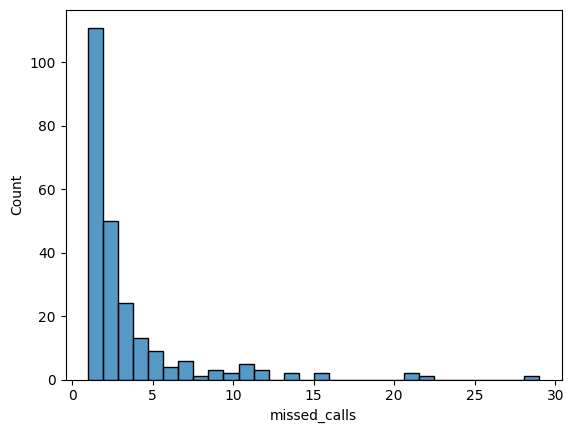

In [ ]:
sns.histplot(in_missed_calls_operators['missed_calls'], bins=30)

## Las operadores con mayor tiempo de espera por llamada

In [ ]:

t_data['wait_time'] = t_data['total_call_duration'] - t_data['call_duration'] 
wait_operators = t_data.groupby('operator_id')['wait_time'].mean().reset_index()
wait_operators = wait_operators.sort_values(by='wait_time', ascending=False).reset_index(drop=True)
wait_operators.head(10)


,operator_id,wait_time
0,925922,98.457384
1,885890,95.452226
2,929428,88.755714
3,885876,80.270690
4,908640,57.607692
5,929426,55.275980
6,945278,47.641319
7,919364,47.357752
8,945286,36.429577
9,945904,35.477632


<Axes: xlabel='wait_time', ylabel='Count'>

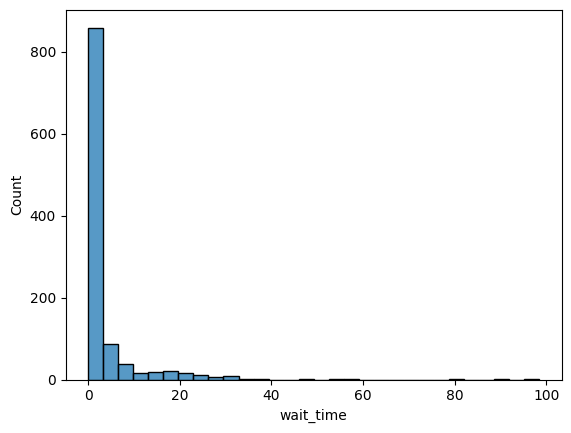

In [ ]:
sns.histplot(wait_operators['wait_time'], bins=30)

## Operadores con menos llamadas realizadas

In [ ]:
out_calls = t_data[t_data['direction'] == 'out']
out_calls_operators = out_calls.groupby('operator_id').size().reset_index(name='out_calls')
out_calls_operators = out_calls_operators.sort_values(by='out_calls', ascending=True).reset_index(drop=True)
out_calls_operators.head()

,operator_id,out_calls
0,890234,1
1,882478,1
2,966686,1
3,883018,1
4,969262,1


Text(0, 0.5, 'Frecuencia')

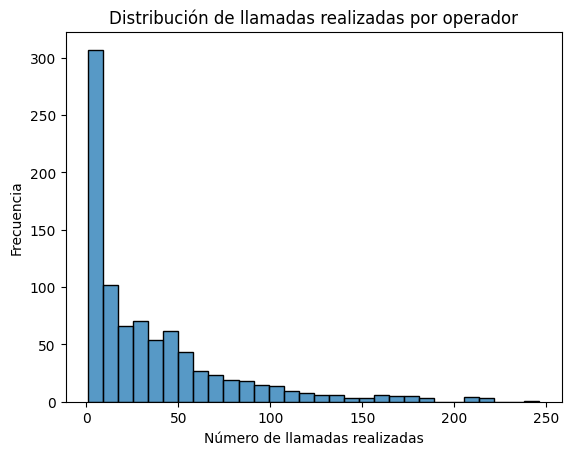

In [ ]:
sns.histplot(out_calls_operators['out_calls'], bins=30)
plt.title('Distribución de llamadas realizadas por operador')
plt.xlabel('Número de llamadas realizadas')
plt.ylabel('Frecuencia')


<Axes: xlabel='out_calls'>

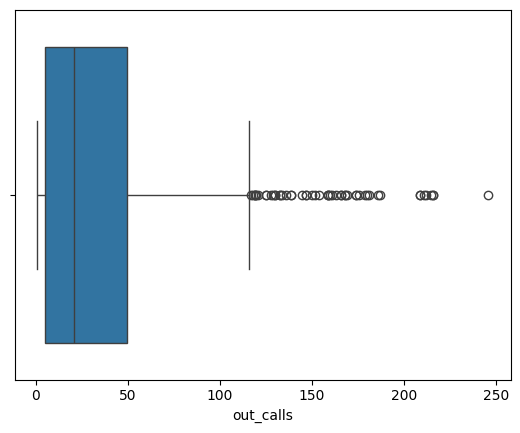

In [ ]:
sns.boxplot(x='out_calls', data=out_calls_operators)

# Historiograma de la duracion total de las llamadas

## Con total call duration

<Axes: xlabel='total_call_duration', ylabel='Count'>

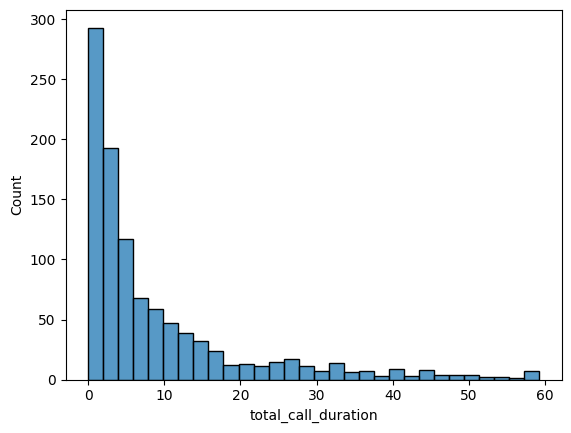

In [ ]:
total_call_duration = t_data.groupby('operator_id')['total_call_duration'].mean().reset_index()
total_call_duration = total_call_duration[total_call_duration['total_call_duration'] < 60] # Filtrar duraciones mayores a 60 minutos

sns.histplot(total_call_duration['total_call_duration'], bins=30)

9.227254973636436


<Axes: xlabel='total_call_duration'>

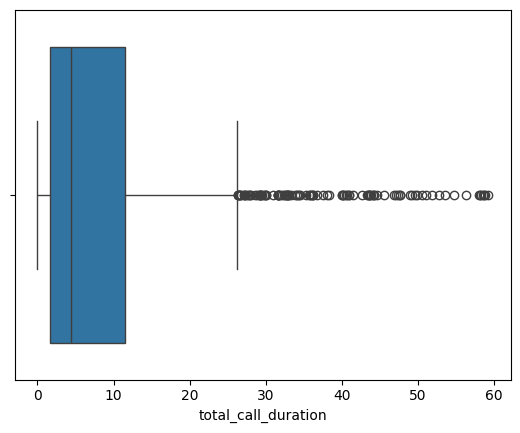

In [ ]:
print(total_call_duration['total_call_duration'].mean())

sns.boxplot(x='total_call_duration', data=total_call_duration)

## Con real duration

<Axes: xlabel='call_duration', ylabel='Count'>

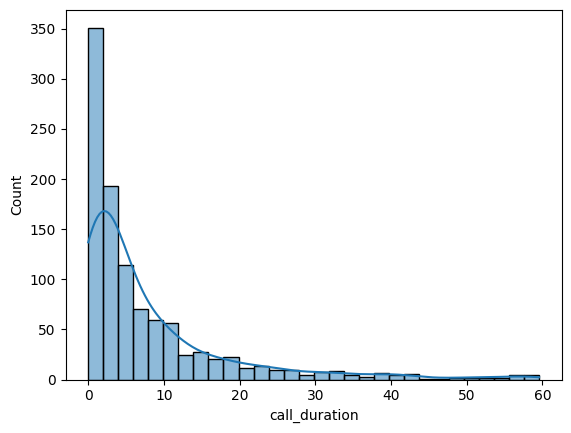

In [ ]:
real_call_duration = t_data.groupby('operator_id')['call_duration'].mean().reset_index()
real_call_druation = real_call_duration[real_call_duration['call_duration'] < 60] # Filtrar duraciones mayores a 60 minutos

sns.histplot(real_call_druation['call_duration'], bins=30, kde=True)

7.96926051446148


<Axes: xlabel='call_duration'>

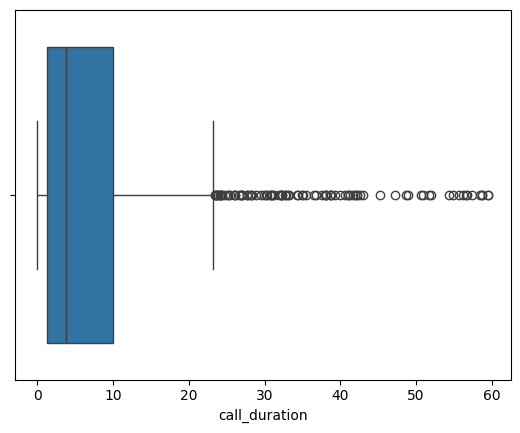

In [ ]:
print(real_call_druation['call_duration'].mean())

sns.boxplot(x='call_duration', data=real_call_druation)

# Repetire los analisis anteriores ahora agrupados por dia 

## Colocar los materiales en orden

Text(0, 0.5, 'llamadas por fecha')

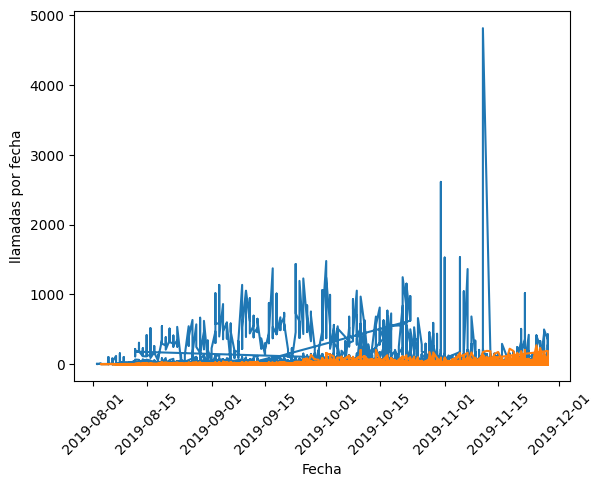

In [ ]:
plt.plot(out_calls['date'], out_calls['calls_count'], label='salientes')
plt.plot(in_calls['date'], in_calls['calls_count'], label='entrantes')
plt.xlabel('Fecha')
plt.xticks(rotation=45)
plt.ylabel('llamadas por fecha')

# Conclusiones generales:

Se encontró que haymuchos operadores que no hacen casi ninguna llamada saliente, podríamos obtener los datos de estos operadores haciendo un simple filtro de la tabla en la que cortemos las llamadas salientes y pongamos el número de llamadas que deberían hacer, buscando todos aquellos que hacen menos que estas, lo que pasa es que no cuento con esta información entonces, y son muchos IDs los que saldrían.

Se encontró que durante las últimas semanas ha cecido significativamente las llamadas salientes, y un poco las entrantes, probablemente a la implementación de una guía de seguimiento por usuario registrado.

Hay llamadas con una duración de hasta 40 horas es una locura, y se tuvieron que filtrar, pero las llamadas en promedio ya con filtro duran aproximadamente 8 minutos efectivos, y con tiempo de espera esto se eleva a solo 9 minutos, por lo que son llamadas eficientes. Valdría la pena revisar qué usuarios tienen las llamadas más largas, pero requeriría de un criterio de ¿cuanto tiempo ya no es aceptable? para poder encontrar estos IDs, y podríamos hacer lo mismo con los operadores que más tiempo de espera tienen.
